Notebook for testing nn performance

2022-11-01 14:26:19.546357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[(0.0, 0.0), (0.0161, 7.46e-05), (0.0709, 0.000329), (0.125582, 0.000584), (0.180231, 0.000838), (0.234808, 0.00109), (0.289311, 0.00135), (0.343741, 0.0016), (0.398099, 0.00186), (0.452384, 0.00211), (0.506597, 0.00237), (0.58932, 0.00275), (0.740654, 0.00347), (0.891427, 0.00418), (1.041643, 0.0049), (1.191305, 0.00561), (1.340418, 0.00632), (1.488984, 0.00704), (1.637007, 0.00775), (1.784492, 0.00847), (1.931441, 0.00918), (2.096868, 0.00999), (2.307293, 0.011), (2.516628, 0.012), (2.724883, 0.0131), (2.932067, 0.0141), (3.138192, 0.0151), (3.343266, 0.0162), (3.5473, 0.0172), (3.750304, 0.0182), (3.952287, 0.0193), (4.159156, 0.0203), (4.379123, 0.0215), (4.59789, 0.0226), (4.815468, 0.0237), (5.031871, 0.0249), (5.24711, 0.026), (5.461198, 0.0271), (5.674144, 0.0283), (5.885962, 0.0294), (6.096663, 0.0305), (6.24499, 0.0316), (6.320205, 0.0326), (6.395337, 0.0336), (6.470317, 0.0346), (6.545148, 0.0356), (6.619829, 0.0366), (6.694361, 0.0375), (6.768747, 0.0385), (6.842986, 0.0395

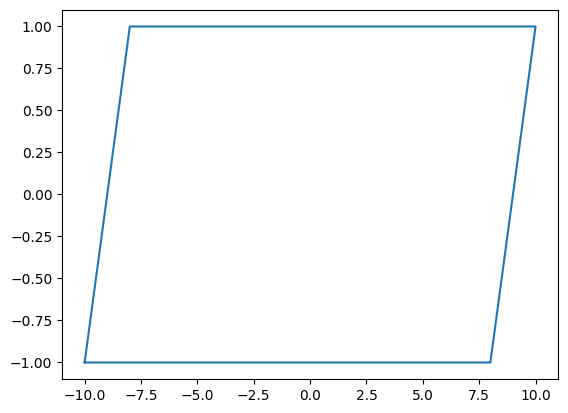

In [2]:
# import dependencies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from data_preprocessing import extract_csv_info, format_data, shuffle_and_split, split_input_output
from neural import train_and_generate_feedforward_network, train_and_generate_recurrent_network, train_and_generate_preisach_network, train_and_generate_recurrent_preisach_network

In [3]:
# Function to compute MSE of predicted values
def compute_mse(actual_y, predicted_y):
    actual_y = np.asarray(actual_y)
    predicted_y = np.asarray(predicted_y)
    diff = np.subtract(actual_y, predicted_y)
    squared = np.square(diff)
    mse = np.mean(squared)
    return mse


# test compute mse
# y = [11, 20, 19, 17, 10]
# y_pred = [12, 18, 19.5, 18, 9]
# print(compute_mse(y, y_pred))

In [4]:
# Function for plotting predicted values from NN
# TODO: add figsize and xlim as input to function to allow customization
def plot_predicted(next_h, next_b, model_name):
    plt.figure(figsize=(20, 12))
    plt.xlim(-750, 750)
    plt.plot(next_h, next_b, marker="o", color='black')
    plt.title(model_name + " Output Plot")
    plt.xlabel("Magnetic Field H (T)")
    plt.ylabel("Magnetic Flux B (A/m)")
    plt.show()

## Data Loading and Preprocessing

In [5]:
# Load data for training
raw_train_data = extract_csv_info("./data_simulated/M19_29Gauge - Sheet1.csv")
# format into (current H, current B, next H, next B)
formatted_data = format_data(raw_train_data)
#train, test = shuffle_and_split(formatted_data)
train_x, train_y = split_input_output(formatted_data)
#test_x, test_y = split_input_output(test)
print(len(train_x))

2000


In [6]:
# Load data for testing
raw_test_data = extract_csv_info("./data_simulated/M19_TESTINGDATA - M19_TESTINGDATA.csv")
formatted_test_data = format_data(raw_test_data)
test_x, test_y = split_input_output(formatted_test_data)

# Separate next_h values into separate list for plotting output
test_next_h = list()
for i in range(len(test_x)):
    test_next_h.append(test_x[i][2])

print(len(test_next_h))
print(len(test_x))

1177
1177


## Feedforward Network

In [ ]:
# Generate and train feedforward network
feedforward_model = train_and_generate_feedforward_network(train_x, train_y, "feedforward.model", n_epochs=20)

In [ ]:
# Load feedforward model
feedforward_model = tf.keras.models.load_model("./models/feedforward.model")

In [ ]:
# Evaluate feedforward network
feedforward_prediction = feedforward_model.predict(test_x)
mse = compute_mse(test_y, feedforward_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
feedforward_model.evaluate(test_x, test_y)

In [ ]:
# Plot feedforward output
plot_predicted(test_next_h, feedforward_prediction, "Feedforward Network")

## Preisach Network

In [ ]:
# Generate and train preisach network
pnn_model = train_and_generate_preisach_network(train_x, train_y, "preisach.model", n_epochs=20)

In [ ]:
# Load preisach model
pnn_model = tf.keras.models.load_model("./models/preisach.model")

In [ ]:
#Evaluate preisach model
pnn_prediction = pnn_model.predict(test_x)
mse = compute_mse(test_y, pnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
pnn_model.evaluate(test_x, test_y)

In [ ]:
# Plot Preisach output
plot_predicted(test_next_h, pnn_prediction, "Preisach Network")

## Recurrent Network
no stop activation layer

In [ ]:
# Generate and train recurrent network (no stop operator)
rnn_model = train_and_generate_recurrent_network(train_x, train_y, "recurrent.model", n_epochs=20)

In [ ]:
# Load recurrent network
rnn_model = tf.keras.models.load_model("./models/recurrent.model")

In [ ]:
# Evaluate recurrent model
rnn_prediction = rnn_model.predict(test_x)
mse = compute_mse(test_y, rnn_prediction)
print("MSE: " + str(mse))

# tensorflow evaluation
rnn_model.evaluate(test_x, test_y)

## Recurrent Preisach Network
includes stop activation layer

In [7]:
# Generate and train recurrent preisach network
n = 50
rnn_model = train_and_generate_recurrent_preisach_network(train_x[0:1984], train_y[0:1984], "recurrent_preisach.model", n_epochs=n)

2022-11-01 14:26:27.641209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50


ValueError: in user code:

    File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/venv/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/venv/lib/python3.10/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/venv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/tn/1x0fpd8x7fx8907x36x25ldw0000gn/T/__autograph_generated_file2j_uq8lu.py", line 271, in tf__call
        ag__.if_stmt(ag__.ld(self).activation is not None, if_body_10, else_body_10, get_state_13, set_state_13, ('do_return', 'retval_', 'outputs'), 2)
    File "/var/folders/tn/1x0fpd8x7fx8907x36x25ldw0000gn/T/__autograph_generated_file2j_uq8lu.py", line 231, in if_body_10
        ag__.for_stmt(ag__.ld(unstacked_outputs), None, loop_body_2, get_state_11, set_state_11, ('unstacked_outputs[i]', 'i'), {'iterate_names': 'output'})
    File "/var/folders/tn/1x0fpd8x7fx8907x36x25ldw0000gn/T/__autograph_generated_file2j_uq8lu.py", line 208, in loop_body_2
        unstacked_out = [ag__.converted_call(ag__.ld(stop_operator_tensor), (ag__.converted_call(ag__.ld(tf).math.subtract, (ag__.ld(unstacked_in)[0], ag__.converted_call(ag__.ld(tf).math.add, (ag__.ld(self).prev_in[ag__.ld(i)], ag__.ld(self).prev_out[ag__.ld(i)]), None, fscope)), None, fscope),), None, fscope)]

    ValueError: Exception encountered when calling layer "recurrent_preisach_layer3" "                 f"(type RecurrentPreisachLayer3).
    
    in user code:
    
        File "/Users/niilovuokila/Documents/GitHub/ecse458_plotter/custom_activation.py", line 221, in call  *
            unstacked_out = [stop_operator_tensor(
    
        ValueError: slice index 10 of dimension 0 out of bounds. for '{{node sequential/recurrent_preisach_layer3/strided_slice_20}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](sequential/recurrent_preisach_layer3/ReadVariableOp_20, sequential/recurrent_preisach_layer3/strided_slice_20/stack, sequential/recurrent_preisach_layer3/strided_slice_20/stack_1, sequential/recurrent_preisach_layer3/strided_slice_20/stack_2)' with input shapes: [10], [1], [1], [1] and with computed input tensors: input[1] = <10>, input[2] = <11>, input[3] = <1>.
    
    
    Call arguments received by layer "recurrent_preisach_layer3" "                 f"(type RecurrentPreisachLayer3):
      • inputs=tf.Tensor(shape=(32, 1), dtype=float32)


In [ ]:
rnn_prediction = rnn_model.predict(test_x[0:1152])
plot_predicted(test_next_h[0:1152], rnn_prediction[0:1152], "R Preisach Network (trained with {} epochs)".format(n))